In [ ]:
#| default_exp ocm

# ocm

> Primitive classes for constructing object-centric models (OCMs) for ARC tasks

An ARC task can be described using an input grid model and an output grid model.

- The input OCM describes the variant and invariant properties of valid grids for a given task
  -  e.g. the input grid size, the presence of certain distinct colored shapes/patterns, etc.
-  The output OCM describes how the properties and objects of an output grid are derived/constructed based on an input grid and the objects contained therein.

In [ ]:
#| hide
from nbdev.showdoc import *
import random
import matplotlib.pyplot as plt
from arcsolver.task import ArcTask, train_tasks, ArcGrid, ArcPair
from fastcore.test import *

In [ ]:
#| hide
random.seed(123)

In [ ]:
#| export
from fastcore.utils import *
from enum import Enum
from typing import ClassVar, List, Optional, Tuple, Union, Literal
import numpy as np
from pydantic import BaseModel, Field, field_validator, model_validator
from scipy import ndimage

## Properties

First we will define a few classes for declaring properties of grids and their objects

In [ ]:
#| export
class Vector(BaseModel):
    "2D vector for positions, sizes, and directions."
    i: int
    j: int

    def __init__(self, i: int, j: int):
        super().__init__(i=i, j=j)

    def to_array(self) -> np.ndarray:
        return np.array([self.i, self.j], dtype=int)

    @classmethod
    def from_array(cls, a: Union[np.ndarray, List, Tuple]) -> 'Vector':
        if not isinstance(a, np.ndarray): a = np.array(a)
        if a.shape != (2,) or a.dtype != int:
            raise ValueError("Need 1D array with 2 ints")
        return cls(i=int(a[0]), j=int(a[1]))

    def __add__(self, o): return Vector(i=self.i + o.i, j=self.j + o.j)
    def __sub__(self, o): return Vector(i=self.i - o.i, j=self.j - o.j)
    def __mul__(self, s): return Vector(i=self.i * s, j=self.j * s)
    def __rmul__(self, s): return self.__mul__(s)

We will use a `Vector` class for specifying positions etc. in ARC grids. Positions are denoted as an (`i`, `j`) coordinate with respect to the top-left corner of an ARC grid.

In [ ]:
Vector(0,0)

Vector(i=0, j=0)

Addition, subtraction and scalar multiplication are supported

In [ ]:
test_eq(Vector(2,2), Vector(1,1) + Vector(1,1))
test_eq(Vector(6,2), 2*Vector(3,1))
test_ne(Vector(2,3), Vector(3,2))

The `to_array` method returns a numpy array

In [ ]:
Vector(i=3, j=7).to_array()

array([3, 7])

There is also a `from_array` class method, though unpacking is more concise

In [ ]:
test_eq(
    Vector.from_array(np.array([1,2])), 
    Vector(*np.array([1,2]))
)

In [ ]:
#| export
class Color(BaseModel):
    "Represents a color using an integer value (0-9) or a color name."
    value: int = Field(..., ge=0, le=9)
    colors: ClassVar[List[str]] = ['black', 'blue', 'red', 'green', 'yellow', 'grey', 'pink', 'orange', 'cyan', 'brown']
    
    def __init__(self, value: Union[int, str]):
        if isinstance(value, str): value = self.colors.index(value.lower())
        super().__init__(value=value)

    def to_array(self): return np.array([self.value], dtype=int)

    def __str__(self): return f"Color('{self.colors[self.value]}', value={self.value})"
    __repr__ = __str__

There are 10 colors in ARC grids:

In [ ]:
print(Color.colors)

['black', 'blue', 'red', 'green', 'yellow', 'grey', 'pink', 'orange', 'cyan', 'brown']


The `Color` class holds the mapping, allowing us to instantiate color properties using either the name or integer value

In [ ]:
Color('blue')

Color('blue', value=1)

In [ ]:
test_eq(Color('green'), Color(3))

In [ ]:
#| export
class Direction(Enum):
    "Represents cardinal and intercardinal directions as 2D vectors."
    UP = Vector(i=-1, j=0)
    DOWN = Vector(i=1, j=0)
    LEFT = Vector(i=0, j=-1)
    RIGHT = Vector(i=0, j=1)
    NE = Vector(i=-1, j=1)
    SW = Vector(i=1, j=-1)
    NW = Vector(i=-1, j=-1)
    SE = Vector(i=1, j=1)

    def to_array(self): return self.value.to_array()

    @classmethod
    def from_array(cls, arr: np.ndarray) -> 'Direction':
        v = Vector(*arr)
        for dir in cls:
            if dir.value == v: return dir
        raise ValueError(f"No direction matches {v}")

With `Direction`, we can describe objects such as a line by their start position, length and direction.

In [ ]:
Direction.UP.value

Vector(i=-1, j=0)

## Objects

The core primitive in ARC tasks is the concept of an `Object`, located at a `position` somewhere in the grid. We will define specific classes for different shapes that will each inherit from this base clase.

In [ ]:
#| export
class Object(BaseModel):
    "Base class for shape objects in ARC tasks."
    position: Vector

    def _get_shape_array(self) -> np.ndarray:
        "Abstract method for getting the shape's array without positioning."
        raise NotImplementedError("Subclasses must implement this method")

In [ ]:
#| export
class Rectangle(Object):
    "Rectangular shape."
    size: Vector
    color: Color

    def _get_shape_array(self) -> np.ndarray:
        return np.full(self.size.to_array(), self.color.value, dtype=int)

The simplest object is a `Rectangle`, which represents any contiguous rectangular sub-array within the grid. A singleton cell is just a `Rectangle` of size `Vector(1,1)`

We give each specific shape a `_get_shape_array` private method for converting it into a numpy array, e.g.:

In [ ]:
rec = Rectangle(position=Vector(0,0), size=Vector(3,3), color=Color('red'))
rec._get_shape_array()

array([[2, 2, 2],
       [2, 2, 2],
       [2, 2, 2]])

In [ ]:
#| export
class Line(Object):
    "Line shape."
    direction: Direction
    length: int = Field(..., gt=0)
    color: Color

    def _get_shape_array(self) -> np.ndarray:
        if self.direction in [Direction.UP, Direction.DOWN]: shape = (self.length, 1)
        elif self.direction in [Direction.LEFT, Direction.RIGHT]: shape = (1, self.length)
        else: shape = (self.length, self.length)

        arr = np.full(shape, -1)
        if self.direction in [Direction.UP, Direction.DOWN, Direction.LEFT, Direction.RIGHT]:
            arr.fill(self.color.value)
        elif self.direction in [Direction.NE, Direction.SW]:
            np.fill_diagonal(np.fliplr(arr), self.color.value)
        else:  # NW, SE
            np.fill_diagonal(arr, self.color.value)
        return arr

ARC grids often feature straight line objects; e.g. spanning the grid, connecting more complex shapes, etc. To allow us to capture both horizontal/vertical and diagonal lines, we'll create a new primitive.

For diagonal lines, the `_get_shape_array` method will return a 2d array with the color value along the appropriate diagonal and `-1` elsewhere

In [ ]:
l = Line(position=Vector(5,5), direction=Direction.NW, length=4, color=Color(3))
l._get_shape_array()

array([[ 3, -1, -1, -1],
       [-1,  3, -1, -1],
       [-1, -1,  3, -1],
       [-1, -1, -1,  3]])

Note that the position of an object in the grid always refers to its top-left corner. For an orthogonal line with direction `UP` or `LEFT`, or for diagonal lines with direction `NW`, `NE` or `SW`, we will need to subtract an offset to determine the object's correct position.

In [ ]:
#| export
#| hide
@patch(as_prop=True)
def offset(self: Line) -> Vector:
        "Calculate the offset of the line based on its direction."
        if self.direction == Direction.UP: return Vector(-self.length + 1, 0)
        elif self.direction == Direction.LEFT: return Vector(0, -self.length + 1)
        elif self.direction == Direction.NW: return Vector(-self.length + 1, -self.length + 1)
        elif self.direction == Direction.NE: return Vector(-self.length + 1, 0)
        elif self.direction == Direction.SW: return Vector(0, -self.length + 1)
        return Vector(0, 0)

In [ ]:
l.offset

Vector(i=-3, j=-3)

In [ ]:
#| export
class Bitmap(Object):
    "Multi-colored bitmap pattern."
    data: np.ndarray

    model_config = {"arbitrary_types_allowed": True}

    @field_validator('data')
    @classmethod
    def validate_data(cls, v):
        if not isinstance(v, np.ndarray): raise ValueError('Must be a numpy array')
        if v.ndim != 2: raise ValueError('Must be a 2D array')
        if v.dtype != int: raise ValueError('Array must contain integer values')
        if np.any(v < -1) or np.any(v > 9): raise ValueError('Array values must be between -1 and 9')
        return v

    def _get_shape_array(self) -> np.ndarray: return self.data

    @property
    def size(self) -> Vector: return Vector.from_array(self.data.shape)

    def rotate(self, n=1): return Bitmap(position=self.position, data=np.rot90(self.data, k=n))
    def flip(self, axis): return Bitmap(position=self.position, data=np.flip(self.data, axis=axis))

The `Bitmap` object represents more complex shapes and patterns, including multi-colored patterns.

In [ ]:
b = Bitmap(position=Vector(2,3), data=np.array([[3,0],[3,3],[0,3]])); b

Bitmap(position=Vector(i=2, j=3), data=array([[3, 0],
       [3, 3],
       [0, 3]]))

We can now define a general `to_array` method for all objects

In [ ]:
#| export
@patch
def to_array(self: Object, grid_size: Optional[Vector] = None) -> np.ndarray:
    """
    If grid_size is provided, returns the object positioned within a grid of that size.
    If grid_size is None, returns just the object's array.
    """
    obj_arr = self._get_shape_array()
    if not grid_size: return obj_arr

    full = np.full(grid_size.to_array(), -1, dtype=int)
    offset = self.offset if isinstance(self, Line) else Vector(i=0, j=0)
    obj_pos = self.position + offset

    if obj_pos.i >= grid_size.i or obj_pos.j >= grid_size.j: return full

    # Allow negative positions to crop the object
    if obj_pos.i < 0:
        obj_arr = obj_arr[-obj_pos.i:]
        obj_pos.i = 0
    if obj_pos.j < 0:
        obj_arr = obj_arr[:, -obj_pos.j:]
        obj_pos.j = 0

    # Crop the object if it goes beyond the grid
    obj_arr = obj_arr[:min(grid_size.i - obj_pos.i, obj_arr.shape[0]),
                      :min(grid_size.j - obj_pos.j, obj_arr.shape[1])]

    full[obj_pos.i:obj_pos.i + obj_arr.shape[0],
         obj_pos.j:obj_pos.j + obj_arr.shape[1]] = obj_arr
    return full

Let's check the `Line` object we created. For now, we'll just use matplotlib's `imshow` to visualise the array

It's a line of length 4, starting at (5,5) and extending in a NW direction.

In [ ]:
l

Line(position=Vector(i=5, j=5), direction=<Direction.NW: Vector(i=-1, j=-1)>, length=4, color=Color('green', value=3))

When we use the `grid_size` argument, it will place the object in the correct position within a larger array

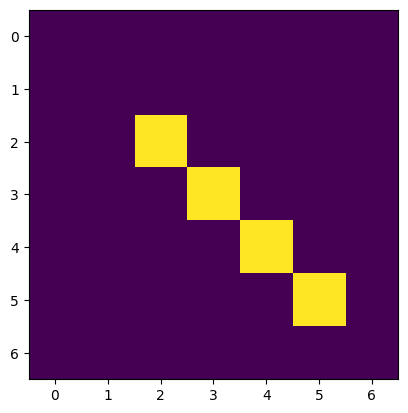

In [ ]:
plt.imshow(
    l.to_array(grid_size=Vector(7,7))
);

## Grid

The final primitive is a container for multiple objects representing a grid.

In [ ]:
#| export
class Grid(BaseModel):
    "Grid container with a size, background color, and objects."
    size: Vector  # Size of the grid (r x c)
    background_color: Optional[Color] = None  # Must be provided if the object layers do not cover the entire grid.
    objects: List[Object] = Field(default_factory=list)  # List of objects contained in the grid.

    def to_array(self) -> np.ndarray:
        grid = self._create_grid(self.size, self.objects)
        # Only replace -1 values with background color if it exists
        if self.background_color is not None:
            grid = np.where(grid == -1, self.background_color.value, grid)
        return grid

    def _create_grid(self, size: Vector, objects: List[Object]) -> np.ndarray:
        "Create grid array without using background color."
        grid = np.full(size.to_array(), -1, dtype=int)
        for obj in objects:
            obj_array = obj.to_array(size)
            if self.background_color is not None:
                obj_array[obj_array == self.background_color.value] = -1
            grid = np.where(obj_array != -1, obj_array, grid)
        return grid

    @model_validator(mode='after')
    def validate_grid_coverage(self) -> 'Grid':
        if self.background_color is None:
            grid = self._create_grid(self.size, self.objects)
            if np.any(grid == -1):
                raise ValueError("When background_color is not provided, objects must cover the entire grid")
        return self

Now we have everything we need to define grid models.

## Example

Let's define grid models for an ARC task

In [ ]:
t = random.choice(train_tasks)
task = ArcTask(t); task

ArcTask(id='d037b0a7', train_examples=3, test_examples=1)

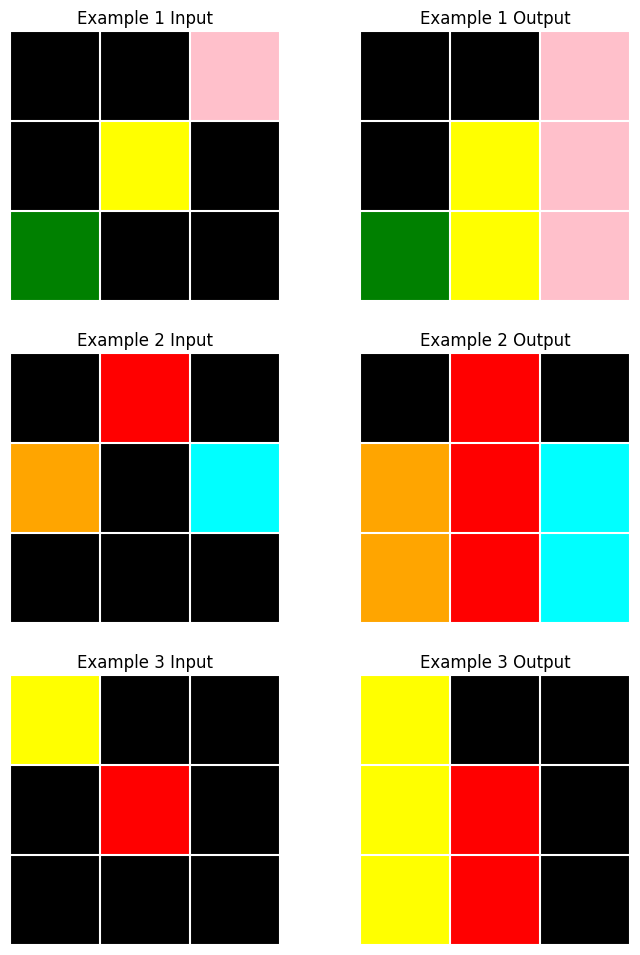

In [ ]:
task.plot()

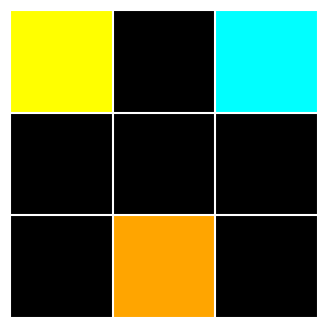

In [ ]:
task.test[0].input.plot()

The input grids are all 3x3 and have a black background, containing at least one singleton colored cell. It's simple to define a model for valid grids in this task:

In [ ]:
class InputModel(Grid):
    size: Literal[Vector(3, 3)]
    background_color: Literal[Color(0)] = Color(0)

    @classmethod
    def from_array(cls, arr: np.ndarray) -> 'InputModel':
        # Find non-black cells
        non_black_positions = np.argwhere(arr != Color(0).value)
        
        return cls(
            size=Vector(*arr.shape),
            objects=[
                Rectangle(position=Vector(i=row, j=col),
                          size=Vector(1,1),
                          color=Color(c))
                for row, col in non_black_positions
                for c in [arr[row, col]]
            ]
        )

The `from_array` class method parses an arbitrary numpy array and creates an instance of this Grid class (assuming that the array is a valid example of a grid from this task).

We can test that the input model is correctly parsing the grid by testing if its `to_array` method reconstructs the original array.

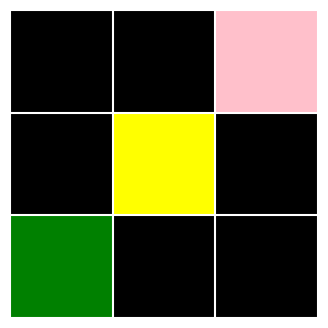

In [ ]:
in_grid = InputModel.from_array(task.train[0].input.data)
ArcGrid(data=in_grid.to_array()).plot()

In [ ]:
for example in task.train:
    in_arr = example.input.data
    test_eq(in_arr, InputModel.from_array(in_arr).to_array())

An output model for this task just needs to construct vertical lines starting at each colored cell and extending down to the bottom of the grid.

In [ ]:
class OutputModel(Grid):
    @classmethod
    def from_input(cls, input_grid: InputModel) -> 'OutputModel':
        size = input_grid.size
        # construct vertical lines extending downward from each colored point
        objects = [
            Line(position=o.position, direction=Direction.DOWN, length=3-o.position.i, color=o.color)
            for o in input_grid.objects
        ]

        return cls(
            size=size,
            background_color=input_grid.background_color,
            objects=objects
        )

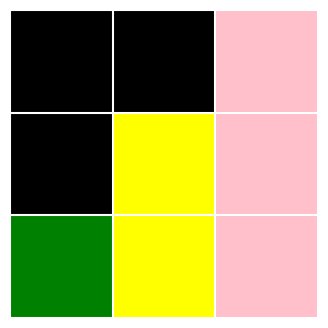

In [ ]:
out_grid = OutputModel.from_input(in_grid)
ArcGrid(out_grid.to_array()).plot()

Let's test it out on the test example

In [ ]:
in_grid_test = InputModel.from_array(
    task.test[0].input.data
)
out_grid_test = OutputModel.from_input(in_grid_test)

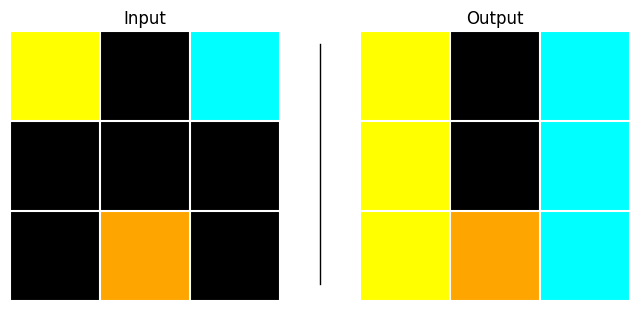

In [ ]:
ArcPair(
    input_grid=in_grid_test.to_array(),
    output_grid=out_grid_test.to_array()
).plot()

Looks good! Let's double check against the hidden test array

In [ ]:
ArcGrid(task.test[0].output.data) == ArcGrid(out_grid_test.to_array())

True

## Helper Functions

We can define a few helper functions for perfoming common operations in ARC tasks

In [ ]:
#| export
class ShapeExtractor:
    'Extract distinct "shapes" (i.e. contiguous regions of the same value) from a numpy array'
    # Define the connectivity structures as class attributes
    ORTH = np.array([[0,1,0], [1,1,1], [0,1,0]])
    DIAG = np.ones((3,3))

    @staticmethod
    def extract_contiguous_regions(
        array: np.ndarray,
        value: int,
        include_diagonal: bool = False,
        background_color: Optional[int] = None
    ) -> List[Tuple[np.ndarray, Tuple[int, int]]]:
        """Extract contiguous regions of a specified value from a numpy array. Can include diagonal connections if specified."""
        arr = array.copy()
        mask = (arr == value)
        structure = ShapeExtractor.DIAG if include_diagonal else ShapeExtractor.ORTH
        labeled, _ = ndimage.label(mask, structure=structure)
        slices = ndimage.find_objects(labeled)

        regions = sorted([(np.sum(mask[s]), s, arr[s]) for s in slices],
                         key=lambda x: x[0], reverse=True)
        for region in regions:
            if background_color is not None: region[2][region[2] == background_color] = -1

        return [(r[2], (r[1][0].start, r[1][1].start)) for r in regions]

    @staticmethod
    def extract_largest_shape(
        array: np.ndarray,
        value: int,
        include_diagonal: bool = False,
        background_color: Optional[int] = None
    ) -> Tuple[Optional[np.ndarray], Optional[Tuple[int, int]]]:
        """
        Extract the largest contiguous shape of a specified value from a numpy array."""
        regions = ShapeExtractor.extract_contiguous_regions(array, value, include_diagonal, background_color)
        return regions[0] if regions else (None, None)

    @staticmethod
    def extract_all_shapes(
        array: np.ndarray,  # Numpy array
        include_diagonal: bool = False,  # Consider diagonally adjacent cells as connected or not
        background_color: Optional[int] = None  # Optionally specify a background color to ignore
    ) -> List[Tuple[np.ndarray, Tuple[int, int], int]]:  # List of (sub-array, position, color_value) tuples
        "Extract all shapes of all values from a numpy array."
        all_shapes = []
        for value in np.unique(array):
            if background_color is not None and value == background_color: continue
            shapes = ShapeExtractor.extract_contiguous_regions(array, value, include_diagonal, background_color)
            all_shapes.extend([(shape, pos, value) for shape, pos in shapes])
        return all_shapes

During parsing, almost all ARC tasks involve extracting specific shapes. This helper functions removes the need to implement this logic each time. It contains various static methods, e.g.:

In [ ]:
show_doc(ShapeExtractor.extract_all_shapes)

---

[source](https://github.com/agemoai/arcsolver/blob/main/arcsolver/ocm.py#L260){target="_blank" style="float:right; font-size:smaller"}

### ShapeExtractor.extract_all_shapes

>      ShapeExtractor.extract_all_shapes (array:numpy.ndarray,
>                                         include_diagonal:bool=False,
>                                         background_color:Optional[int]=None)

*Extract all shapes of all values from a numpy array.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| array | ndarray |  | Numpy array |
| include_diagonal | bool | False | Consider diagonally adjacent cells as connected or not |
| background_color | Optional | None | Optionally specify a background color to ignore |
| **Returns** | **List** |  | **List of (sub-array, position, color_value) tuples** |

In [ ]:
#| export
class PatternMatcher:
    """
    A class for finding alignments between patterns in numpy arrays.
    Supports exact matching and partial matching with missing or extra elements.
    """

    @staticmethod
    def find_matches(
        target: np.ndarray,  # The larger array to search in
        pattern: np.ndarray,  # The smaller array containing the pattern to match
        match_type: str = 'exact'  # 'exact', 'allow_missing', or 'allow_extra'
    ) -> List[Tuple[Vector, int]]:
        """
        Find positions where a pattern aligns with a target, sorted by overlap count
        for non-exact matches.
        """
        h, w = pattern.shape
        H, W = target.shape
        matches = []

        for i in range(H - h + 1):
            for j in range(W - w + 1):
                window = target[i:i+h, j:j+w]

                # Get masks for non-zero elements
                pattern_nonzero = pattern != 0
                window_nonzero = window != 0

                # Check for mismatches based on match_type
                if match_type != 'allow_missing':
                    if np.any(window_nonzero & ~pattern_nonzero): continue

                if match_type != 'allow_extra':
                    if np.any(pattern_nonzero & ~window_nonzero): continue

                # Check that overlapping non-zero elements match
                both_nonzero = window_nonzero & pattern_nonzero
                if not np.array_equal(window[both_nonzero], pattern[both_nonzero]): continue

                # Count overlapping non-zero elements and only include non-zero overlaps
                overlap_count = np.sum(both_nonzero)
                if overlap_count > 0:
                    matches.append((Vector(i=i, j=j), int(overlap_count)))

        # Sort matches by overlap count if not exact matching
        if match_type == 'exact': return matches
        return sorted(matches, key=lambda x: x[1], reverse=True)

    @staticmethod
    def find_best_match(
        target: np.ndarray,  # target array
        pattern: np.ndarray,  # the pattern to align
        match_type: str = 'exact'  # can be 'exact', 'allow_missing' or 'allow_extra'
    ) -> Tuple[Vector, int]:  # tuple of (position, overlap_count)
        """Find the best matching position for the pattern in the target."""
        matches = PatternMatcher.find_matches(target, pattern, match_type)
        return matches[0] if matches else (None, 0)

    @staticmethod
    def extract_matching_region(
        target: np.ndarray,
        pattern: np.ndarray,
        position: Vector
    ) -> np.ndarray:
        """Extract the region from the target that matches the pattern."""
        h, w = pattern.shape
        i, j = position.i, position.j
        return target[i:i+h, j:j+w].copy()

Often we have extracted a shape (as a subarray) from a grid and we need to find the positions of other identical shapes within a grid. Another common situation is that we have a partial shape and we need to align it with a full version of the shape in a grid. This class allows us to do that, sliding over the larger array and returning the position that maximises agreement between the subarray and the area of the larger array, e.g.:

In [ ]:
show_doc(PatternMatcher.find_best_match)

---

[source](https://github.com/agemoai/arcsolver/blob/main/arcsolver/ocm.py#L323){target="_blank" style="float:right; font-size:smaller"}

### PatternMatcher.find_best_match

>      PatternMatcher.find_best_match (target:numpy.ndarray,
>                                      pattern:numpy.ndarray,
>                                      match_type:str='exact')

*Find the best matching position for the pattern in the target.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| target | ndarray |  | target array |
| pattern | ndarray |  | the pattern to align |
| match_type | str | exact | can be 'exact', 'allow_missing' or 'allow_extra' |
| **Returns** | **Tuple** |  | **tuple of (position, overlap_count)** |

In [ ]:
#| export
class EnclosureFiller:
    'Fill areas of an array that are "enclosed" by cells of a given value'
    @staticmethod
    def fill_enclosures(mask: np.ndarray) -> np.ndarray:
        """Fill enclosed areas in the given mask that are surrounded by boundary_value."""
        # Convert mask to boolean if it is not already
        mask = mask.astype(bool)
        # Invert boundaries to mark enclosed areas as zeroes.
        inverted_mask = ~mask
        # Label connected components
        labeled_array, _ = ndimage.label(inverted_mask)
        # Create a copy of labeled_array but with zero labels at the border
        border_mask = np.ones_like(labeled_array)
        border_mask[0, :] = border_mask[-1, :] = border_mask[:, 0] = border_mask[:, -1] = 0
        border_labels = np.unique(labeled_array * (1 - border_mask))
        # Set non-border enclosed areas to True (fill them)
        output_mask = np.isin(labeled_array, border_labels, invert=True)
        return output_mask.astype(int)

In [ ]:
#| export
class CyclicPattern(BaseModel):
    """
    Identify, represent, and manipulate cyclic patterns in ARC task grids,
    particularly for tasks involving pattern repetition and extension.
    """
    data: np.ndarray
    period: int
    axis: int = Field(0, ge=0, le=1)

    model_config = {"arbitrary_types_allowed": True}

    @classmethod
    def from_array(cls, arr: np.ndarray, axis: int = 0) -> 'CyclicPattern':
        """Create a CyclicPattern instance from a numpy array."""
        return cls(data=arr, period=cls.find_period(arr, axis), axis=axis)

    @staticmethod
    def find_period(arr: np.ndarray, axis: int = 0) -> int:
        """Find the smallest period along a specified axis of a NumPy array."""
        n = arr.shape[axis]
        if n == 0: return 0  # Undefined period for empty axis

        for p in range(1, n):
            pattern = np.take(arr, indices=range(p), axis=axis)
            repeats = int(np.ceil(n / p))
            tiled = np.concatenate([pattern] * repeats, axis=axis)
            slicer = [slice(None)] * arr.ndim
            slicer[axis] = slice(0, n)
            tiled = tiled[tuple(slicer)]

            if np.array_equal(arr, tiled): return p

        return n  # The entire axis if no smaller period is found

    def extend(self, length: int) -> np.ndarray:
        """Extend the pattern to a specified length."""
        pattern = np.take(self.data, range(self.period), axis=self.axis)
        repeats = [1] * self.data.ndim
        repeats[self.axis] = length // self.period + 1
        tiled = np.tile(pattern, repeats)
        slices = [slice(None)] * self.data.ndim
        slices[self.axis] = slice(length)
        return tiled[tuple(slices)]

    def to_array(self) -> np.ndarray:
        """Convert the cyclic pattern to a numpy array."""
        return self.data

    def __len__(self) -> int:
        """Get the length of the pattern along its axis."""
        return self.data.shape[self.axis]

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()